In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

print(torch.cuda.get_device_name())
print(torch.__version__, torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

NVIDIA RTX A2000 8GB Laptop GPU
2.0.0+cu118 True
cuda:0


In [69]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [108]:
#make dataset 
#input : sequence made from 1 or 2
#output : sum of sequence
num_data = 10000
max_sequence_length = 100
min_sequence_length = 50
#make inputdata randomly
input_list = []
output_list = []

for i in range(num_data):
    sequence_length = random.randint(min_sequence_length, max_sequence_length)
    threshold = random.random()
    input = []
    sum_input = 0
    for j in range(sequence_length):
        random_number = random.random()
        if random_number <= threshold:
            input.append([1])
            sum_input = sum_input + 1
        else:
            input.append([2])
            sum_input = sum_input + 2
    for k in range(max_sequence_length - sequence_length):
        input.append([0])
        
    input_list.append(input)
    output_list.append([sum_input])


In [109]:
output_list[2]

[59]

In [110]:
class MyDataset(Dataset):
    def __init__(self, input_data, output_data):
        super(MyDataset, self).__init__()
        self.input_data = input_data
        self.output_data = output_data

    def __getitem__(self, index):
        input = torch.tensor(self.input_data[index], dtype=torch.float32)
        output = torch.tensor(self.output_data[index], dtype=torch.float32)
        return input, output

    def __len__(self):
        return len(self.input_data)

In [111]:
train_valid_data = MyDataset(input_list, output_list)

val_size = int(0.2 * len(train_valid_data))
train_data, val_data = torch.utils.data.random_split(train_valid_data, [len(train_valid_data)-val_size, val_size])

In [112]:
batch_size = 64

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=True
)

In [113]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=self.num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):    
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        output, _ = self.lstm(x, (h0, c0))
        output = self.fc(output[:,-1,:])
        
        return output

In [163]:
# ハイパーパラメータの設定
input_size = 1
hidden_size = 128
output_size = 1
num_layers = 1
learning_rate = 0.001
num_epochs = 100

# モデルの定義
model = LSTM(input_size, hidden_size, output_size, num_layers).to(device)

In [164]:
# dataの取り出し
Iter = dataloader_train.__iter__()
input_data, output_data = next(Iter)

print(output_data.size())

torch.Size([64, 1])


In [165]:
input_test_data = torch.randn(batch_size, 20, input_size)
input_test_data = input_test_data.to(device)
output = model(input_test_data)
print(output.size())

torch.Size([64, 1])


In [166]:
# 損失関数の定義
criterion = nn.MSELoss()

# オプティマイザの定義
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#トレーニングの開始
train_loss_list, val_loss_list = [], []

for epoch in range(num_epochs):
    train_loss, val_loss = 0, 0
    
    #train_mode
    model.train()
    for i, (input_data, output_data) in enumerate(dataloader_train):
        # データをGPUに転送
        input_data, output_data = input_data.to(device), output_data.to(device)
        
        # モデルの出力を計算
        output = model(input_data)
        
        # 損失関数の適用
        loss = criterion(output, output_data)
        
        #train_lossに結果を蓄積
        train_loss += loss.item()
        
        # 勾配を初期化して逆伝播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # lossの平均を計算
        avg_train_loss = train_loss / len(dataloader_train.dataset)  
        
    #valid_mode
    model.eval()
    with torch.no_grad():
        for input_data, output_data in dataloader_valid:
            # データをGPUに転送
            input_data, output_data = input_data.to(device), output_data.to(device)
            
            # モデルの出力を計算
            output = model(input_data)
            
            # 損失関数の適用
            loss = criterion(output, output_data)
        
            #val_lossに結果を蓄積
            val_loss += loss.item()
    
    # lossの平均を計算      
    avg_val_loss = val_loss / len(dataloader_valid.dataset)
    
    # print log
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}'.format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss))
    
    # append list for polt graph after training
    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)

Epoch [1/100], Loss: 175.3422, val_loss: 146.1957
Epoch [2/100], Loss: 123.9565, val_loss: 105.5004
Epoch [3/100], Loss: 90.2186, val_loss: 75.7877
Epoch [4/100], Loss: 65.7228, val_loss: 55.4817
Epoch [5/100], Loss: 48.1735, val_loss: 40.4818
Epoch [6/100], Loss: 35.9728, val_loss: 30.7398
Epoch [7/100], Loss: 27.8037, val_loss: 24.3789
Epoch [8/100], Loss: 22.5773, val_loss: 20.0718
Epoch [9/100], Loss: 19.4015, val_loss: 17.7411
Epoch [10/100], Loss: 17.5643, val_loss: 16.7691
Epoch [11/100], Loss: 16.5646, val_loss: 15.9079
Epoch [12/100], Loss: 16.0520, val_loss: 15.5412
Epoch [13/100], Loss: 15.8122, val_loss: 15.4262
Epoch [14/100], Loss: 15.7039, val_loss: 15.3438
Epoch [15/100], Loss: 15.6599, val_loss: 15.7068
Epoch [16/100], Loss: 15.6433, val_loss: 15.4541
Epoch [17/100], Loss: 15.6367, val_loss: 15.2665
Epoch [18/100], Loss: 15.6354, val_loss: 15.3157
Epoch [19/100], Loss: 15.6347, val_loss: 15.4816
Epoch [20/100], Loss: 15.6356, val_loss: 15.2185
Epoch [21/100], Loss: 15.

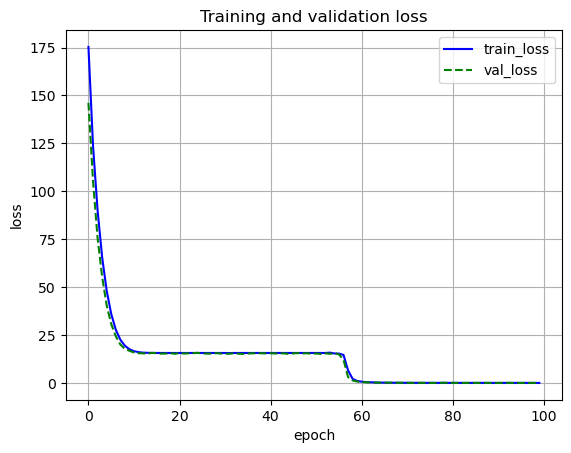

In [167]:
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

In [168]:
class TestDataset(Dataset):
    def __init__(self, test_data):
        self.test_data = test_data

    def __len__(self):
        return len(self.test_data)

    def __getitem__(self, index):
        input = torch.tensor(self.test_data[index], dtype=torch.float32)
        output = 0
        return input, output

In [179]:
#make testdata randomly
test_input_data = []
test_output_data = []

for i in range(1):
    sequence_length = random.randint(min_sequence_length, max_sequence_length)
    threshold = random.random()
    input = []
    sum_input = 0
    for j in range(sequence_length):
        random_number = random.random()
        if random_number <= threshold:
            input.append([1])
            sum_input = sum_input + 1
        else:
            input.append([2])
            sum_input = sum_input + 2
    for k in range(max_sequence_length - sequence_length):
        input.append([0])
        
    test_input_data.append(input)
    test_output_data.append([sum_input])


print(test_input_data)
print(test_output_data)


test_data = TestDataset(test_input_data)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

#予測モード
model.eval()
with torch.no_grad():
    input_data, _ = next(iter(test_loader))
    input_data = input_data.to(device)
    output = model(input_data)

print(output)

[[[1], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [1], [1], [2], [2], [2], [2], [2], [2], [2], [1], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [1], [2], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]]
[[97]]
tensor([[96.8555]], device='cuda:0')
